In [1]:
from pprint import pprint

import pandas as pd
import polars as pl

from continuousvi.continuousVI import ContinuousVI
from continuousvi.simulation import BatchSimulation

/home/yuyasato/work3/libs/ContinuousVI/.venv/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/yuyasato/work3/libs/ContinuousVI/.venv/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
def evaluate(result: pd.DataFrame, target_genes: list[str], use_col_name: str, up: bool = True) -> pl.DataFrame:
    """Evaluate scores of the given result."""
    gt_included = (
        pl.DataFrame(result)
        .sort(use_col_name, descending=up)
        .with_columns(pl.col("gene").is_in(target_genes).alias("gt"))
        .with_row_index("index")
        .with_columns((pl.col("index") < len(target_genes)).alias("pred"))
        .drop("index")
    )
    TP = gt_included.filter(pl.col("gt") & pl.col("pred")).height
    TN = gt_included.filter(~pl.col("gt") & ~pl.col("pred")).height
    FP = gt_included.filter(~pl.col("gt") & pl.col("pred")).height
    FN = gt_included.filter(pl.col("gt") & ~pl.col("pred")).height
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0

    return pl.DataFrame({
        "Accuracy[%]": [accuracy * 100],
        "Precision[%]": [precision * 100],
        "Recall[%]": [recall * 100],
    })

In [3]:
sim = BatchSimulation(library_size_sigma=0.5)

Initializing BatchSimulation with parameters:
  cell_types=['Tcell', 'Bcell', 'Macrophage'], projects=['A', 'B']
  library_size_logmean={'A': 0.3, 'B': -0.3}, dropout_rates={'A': 0.05, 'B': 0.1}
  age_mode=linear
=== Genes Count Summary ===
  Tcell: Up=50, Down=50
  Bcell: Up=50, Down=50
  Macrophage: Up=50, Down=50
  Neutral=700
Project loop: 100%|██████████| 2/2 [00:00<00:00, 13.39it/s]
/home/yuyasato/work3/libs/ContinuousVI/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
=== Final AnnData ===
AnnData object with n_obs × n_vars = 600 × 1000
    obs: 'project_id', 'cell_type', 'age'


In [ ]:
sim.verify_simulation()

[Verification: Up genes] 150/150 genes showed a significant increase at age 90 vs. 10 (p<0.05).
[Verification: Down genes] 150/150 genes showed a significant decrease at age 90 vs. 10 (p<0.05).


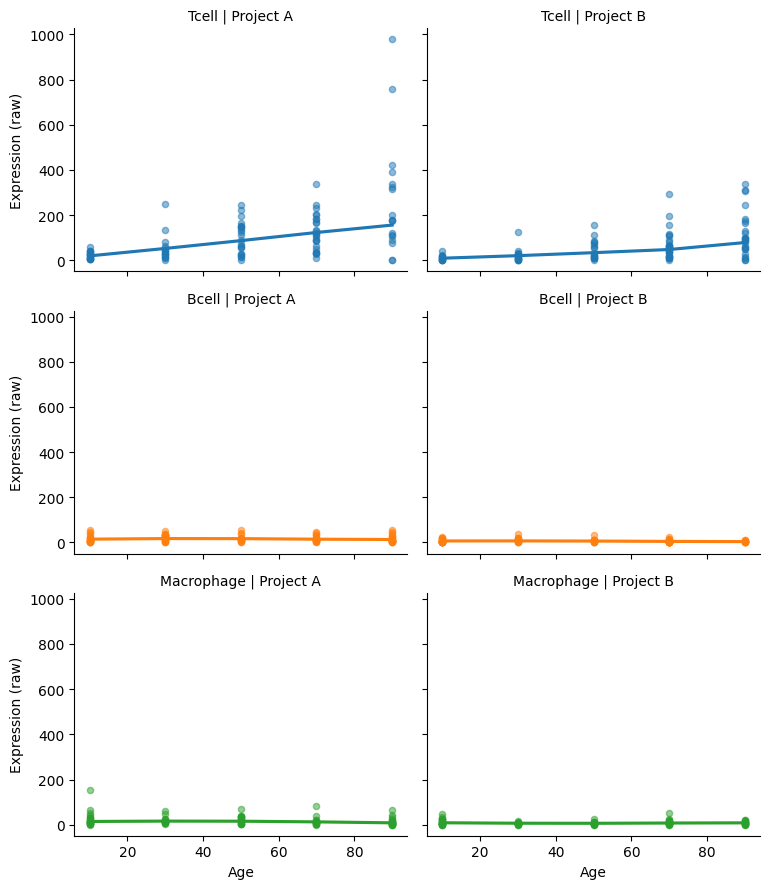

In [30]:
sim.plot_genes_by_age(genes=next(iter(sim.ct_up_genes["Tcell"])))

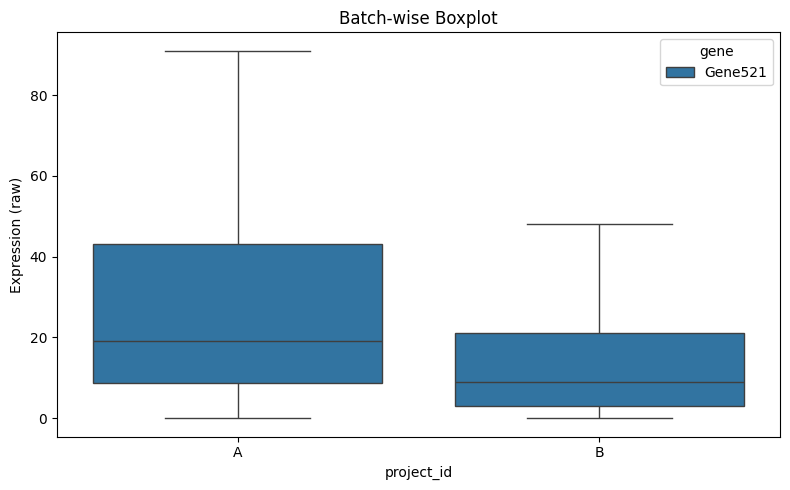

In [31]:
sim.plot_boxplot_by_batch(genes=sim.ct_up_genes["Tcell"][0])


In [4]:
cont = ContinuousVI(sim.adata, batch_key="project_id", label_key="cell_type", continuous_key="age")

In [5]:
import warnings

warnings.filterwarnings("ignore", message="Can't initialize NVML")
trained = cont.train(n_train=1)

Training multiple scVI models:   0%|          | 0/1 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuyasato/work3/libs/ContinuousVI/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/yuyasato/work3/libs/ContinuousVI/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/yuyasato/work3/libs/ContinuousVI/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many worke

Training:   0%|          | 0/800 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 4043.150. Signaling Trainer to stop.


In [6]:
trained.save(
    "./data/continuous/simulation/models",
    overwrite=True,
)

Saving trained model.: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]


In [6]:
# Use first cell type
trained.adata = trained.adata[trained.adata.obs["cell_type"] == sim.cell_types[0]]

In [ ]:
result = trained.regression(n_samples=25, use_mcmc=False)
pprint("@Up (mode=ols)")  # noqa: T203
pprint(evaluate(result, sim.ct_up_genes["Tcell"], use_col_name="Slope_mean", up=True))  # noqa: T203
pprint("@Down (mode=ols)")  # noqa: T203
pprint(evaluate(result, sim.ct_down_genes["Tcell"], use_col_name="Slope_mean", up=False))  # noqa: T203

Fitting regressions (threads): 100%|██████████| 25000/25000 [00:04<00:00, 5654.55it/s]


'@Up (mode=ols)'
shape: (1, 3)
┌─────────────┬──────────────┬───────────┐
│ Accuracy[%] ┆ Precision[%] ┆ Recall[%] │
│ ---         ┆ ---          ┆ ---       │
│ f64         ┆ f64          ┆ f64       │
╞═════════════╪══════════════╪═══════════╡
│ 100.0       ┆ 100.0        ┆ 100.0     │
└─────────────┴──────────────┴───────────┘
'@Down (mode=ols)'
shape: (1, 3)
┌─────────────┬──────────────┬───────────┐
│ Accuracy[%] ┆ Precision[%] ┆ Recall[%] │
│ ---         ┆ ---          ┆ ---       │
│ f64         ┆ f64          ┆ f64       │
╞═════════════╪══════════════╪═══════════╡
│ 100.0       ┆ 100.0        ┆ 100.0     │
└─────────────┴──────────────┴───────────┘


In [ ]:
result = trained.regression(n_samples=25, use_mcmc=True)
result_pos = pl.DataFrame(result).filter(pl.col("Slope_prob_positive") == 1).to_pandas()
result_neg = pl.DataFrame(result).filter(pl.col("Slope_prob_positive") == 0).to_pandas()
pprint("@Up (mode=ols)")  # noqa: T203
pprint(evaluate(result_pos, sim.ct_up_genes["Tcell"], use_col_name="Slope_mean", up=True))  # noqa: T203
pprint("@Down (mode=ols)")  # noqa: T203
pprint(evaluate(result_neg, sim.ct_down_genes["Tcell"], use_col_name="Slope_mean", up=False))  # noqa: T203

MCMC chunks: 100%|██████████| 1/1 [02:33<00:00, 153.63s/it]

'@Up (mode=ols)'
shape: (1, 3)
┌─────────────┬──────────────┬───────────┐
│ Accuracy[%] ┆ Precision[%] ┆ Recall[%] │
│ ---         ┆ ---          ┆ ---       │
│ f64         ┆ f64          ┆ f64       │
╞═════════════╪══════════════╪═══════════╡
│ 100.0       ┆ 100.0        ┆ 100.0     │
└─────────────┴──────────────┴───────────┘
'@Down (mode=ols)'
shape: (1, 3)
┌─────────────┬──────────────┬───────────┐
│ Accuracy[%] ┆ Precision[%] ┆ Recall[%] │
│ ---         ┆ ---          ┆ ---       │
│ f64         ┆ f64          ┆ f64       │
╞═════════════╪══════════════╪═══════════╡
│ 100.0       ┆ 100.0        ┆ 100.0     │
└─────────────┴──────────────┴───────────┘
